In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
MIMIC_PATH = 'datasets/mimic-iii/aggregated_full_cohort_2h/train.csv'
MIMIC_FEATURES = 'datasets/mimic-iii/aggregated_full_cohort_2h/state_space_features.txt'

UMC_PATH = 'datasets/amsterdam-umc-db_v3/aggregated_full_cohort_2h/train.csv'
UMC_FEATURES = 'datasets/amsterdam-umc-db_v3/aggregated_full_cohort_2h/state_space_features.txt'

### Convenience functions

In [3]:
COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
LINESTYLES = ['-', '--', '-.', ':']

In [4]:
def plot_actions(episode_df):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.plot(episode_df.total_iv_fluid.values)
    plt.ylabel('IV fluid dose (ml)')
    plt.xlabel('Time step')
    
    plt.subplot(1, 4, 2)
    plt.plot(episode_df.max_vaso.values)
    plt.ylabel('Maximum vasopressor dose (mcg/kg/min)')
    plt.xlabel('Time step')
    
    plt.subplot(1, 4, 3)
    plt.plot(episode_df.action.values)
    plt.ylabel('Discreteized action')
    plt.xlabel('Time step')
    
    plt.subplot(1, 4, 4)
    plt.plot(episode_df.reward.values)
    plt.ylabel('Reward')
    plt.xlabel('Time step')
    
    plt.suptitle('Actions and rewards')
    plt.tight_layout()
    plt.show()
    
def plot_states(episode_df):
    plt.figure(figsize=(16, 4))
    
    for col in episode_df.filter(regex='x\d+').columns:
        # pick color and linestyle at random
        c = random.choice(COLORS)
        l = random.choice(LINESTYLES)
        plt.plot(episode_df[col].values, c=c, linestyle=l)
        
    plt.ylabel('Standardized value')
    plt.xlabel('Time step')
    
    plt.suptitle('Time series')
    plt.tight_layout()
    plt.show()
    
def print_stats(full_df, feature_labels):
    print('General:')
    print('Total episodes: %d' % full_df.episode.nunique())
    print('Mortality rate: %.2f' % (full_df.groupby('episode').reward.max() == 0).mean())
    print('\nActions:')
    print('Patients on vasopressors: %.2f%%' % (100 * (full_df.action % 5 > 0).groupby(full_df.episode).max().mean()))
    print('Patients on IV fluids:    %.2f%%' % (100 * (full_df.action // 5 > 0).groupby(full_df.episode).max().mean()))
    print('\nPorportion missing during episode:')
    print_missing(full_df, feature_labels=feature_labels)

def print_missing(full_df, feature_labels):
    values_df = full_df.filter(regex='x\d+')
    dct = {x: 0 for x in values_df.columns}
    total = 0
    for _, episode_df in values_df.groupby(full_df.episode):
        has_data = (episode_df.diff() > 1e-4).any()
        for x, changes in has_data.iteritems():
            dct[x] += int(changes)
        total += 1
        
    def normalize(c, total):
        if c / total < 1e-6: # these are static features, they don't change
            return 0.0
        else:
            return 1 - c / total
        
    out = '\n'.join(['%.2f - %s' % (normalize(c, total), feature_labels[x]) for x, c in dct.items()])
    print(out)
            

def load_features(path):
    with open(path, 'r') as file:
        return {'x%d' % i: f.strip() for i, f in enumerate(file.readlines())}

### MIMIC-III

In [5]:
mimic_df = pd.read_csv(MIMIC_PATH)
mimic_feats = load_features(MIMIC_FEATURES)
print_stats(mimic_df, feature_labels=mimic_feats)

General:
Total episodes: 5333
Mortality rate: 0.15

Actions:
Patients on vasopressors: 21.49%
Patients on IV fluids:    100.00%

Porportion missing during episode:
0.79 - max_vaso_prev
0.00 - total_iv_fluid_prev
0.48 - sepsis_antibiotics
0.21 - profyl_antibiotics
0.36 - profyl_other
0.00 - ventilator
0.00 - sirs_score
0.00 - sofa_score
0.00 - weight
0.00 - height
0.00 - age
0.00 - gender
0.00 - elective
0.00 - is_sepsis
0.00 - heart_rate
0.03 - temp
0.00 - mean_bp
0.00 - dias_bp
0.00 - sys_bp
0.00 - resp_rate
0.00 - spo2
0.07 - natrium
0.11 - chloride
0.05 - kalium
0.12 - trombo
0.12 - leu
0.15 - anion_gap
0.29 - aptt
0.12 - art_ph
0.65 - asat
0.67 - alat
0.12 - bicarbonaat
0.21 - art_be
0.35 - ion_ca
0.42 - lactate
0.18 - paco2
0.22 - pao2
0.31 - fio2
0.91 - sirs_bands
0.00 - shock_index
0.10 - hb
0.65 - bilirubin
0.20 - creatinine
0.19 - ureum
0.72 - albumin
0.16 - magnesium
0.21 - calcium
0.29 - pf_ratio
0.07 - glucose
0.86 - svo2
0.42 - cvd
0.99 - d-dimer
0.06 - hematocrit
0.01 - t

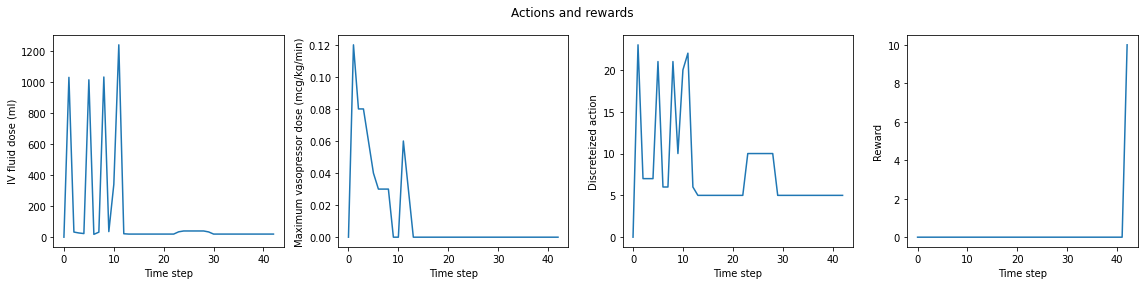

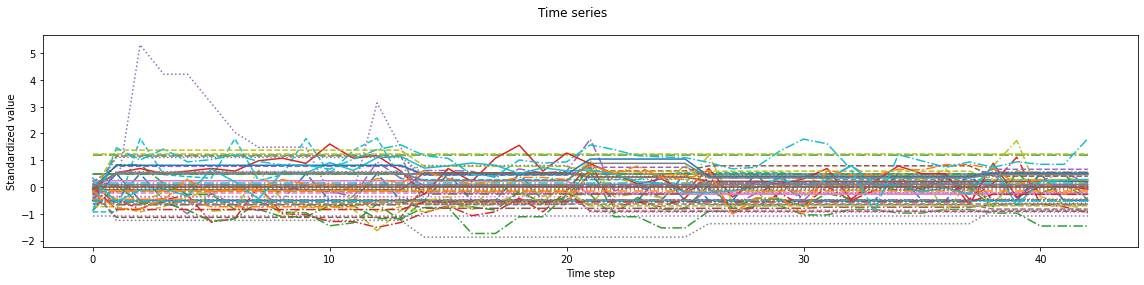

In [11]:
# Select random episode from mimic_df
episode = random.choice(mimic_df.episode.unique())
episode_df = mimic_df[mimic_df.episode == episode]

plot_actions(episode_df)
plot_states(episode_df)

### AmsterdamUMCdb

In [14]:
umc_df = pd.read_csv(UMC_PATH)
umc_feats = load_features(UMC_FEATURES) # same as MIMIC!!!
print_stats(umc_df, feature_labels=umc_feats)

General:
Total episodes: 10688
Mortality rate: 0.13

Actions:
Patients on vasopressors: 48.44%
Patients on IV fluids:    100.00%

Porportion missing during episode:
0.52 - max_vaso_prev
0.00 - total_iv_fluid_prev
0.64 - sepsis_antibiotics
0.39 - profyl_antibiotics
0.72 - profyl_other
0.67 - ventilator
0.00 - sirs_score
0.00 - sofa_score
0.00 - weight
0.00 - height
0.00 - age
0.00 - gender
0.00 - elective
0.00 - is_sepsis
0.01 - heart_rate
0.03 - temp
0.00 - mean_bp
0.00 - dias_bp
0.00 - sys_bp
0.02 - resp_rate
0.00 - spo2
0.04 - natrium
0.46 - chloride
0.03 - kalium
0.12 - trombo
0.17 - leu
0.20 - anion_gap
0.28 - aptt
0.02 - art_ph
0.55 - asat
0.57 - alat
0.02 - bicarbonaat
0.03 - art_be
0.19 - ion_ca
0.51 - lactate
0.03 - paco2
0.03 - pao2
0.52 - fio2
0.99 - sirs_bands
0.00 - shock_index
0.03 - hb
0.63 - bilirubin
0.30 - creatinine
0.51 - ureum
0.46 - albumin
0.26 - magnesium
0.22 - calcium
0.27 - pf_ratio
0.03 - glucose
1.00 - svo2
0.93 - cvd
0.99 - d-dimer
0.04 - hematocrit
0.01 - 

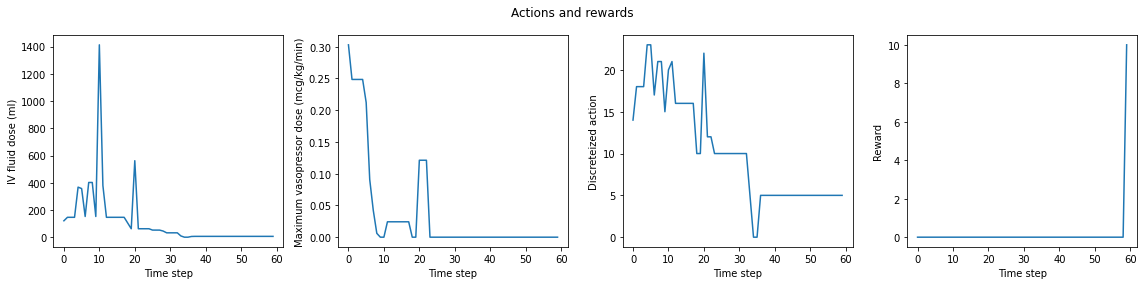

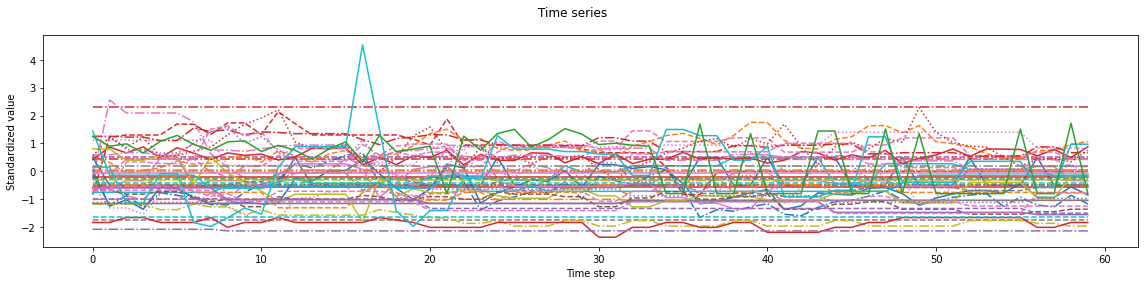

In [26]:
# Select random episode from umc_df
episode = random.choice(umc_df.episode.unique())
episode_df = umc_df[umc_df.episode == episode]

plot_actions(episode_df)
plot_states(episode_df)